## Setup and Configuration

In [1]:
import json
from pathlib import Path
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt

from utils import (
    parse_output_types, get_optimal_resize_width,
    enumerate_aso_variants, plot_all_outputs, find_exon_sequence,
    score_asos_and_export
)
from alphagenome.models import dna_client
from alphagenome.data import genome, gene_annotation, transcript as transcript_utils
from alphagenome.visualization import plot_components

# Load config
config_name = 'SETD5_e2'  # Change config file here
with open(f'config_private/{config_name}.json', 'r', encoding='utf-8') as f:
    cfg = json.load(f)

cfg['results_dir'] = cfg['results_dir'] + '/ASO'
Path(cfg['data_dir']).mkdir(parents=True, exist_ok=True)
Path(cfg['results_dir']).mkdir(parents=True, exist_ok=True)
Path(f"{cfg['results_dir']}/{cfg['gene_symbol'].lower()}").mkdir(parents=True, exist_ok=True)

# Initialize model and annotations
model = dna_client.create(cfg['dna_api_key'])
gtf = pd.read_feather(cfg['gtf_url'])
gene_interval = gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol'])

# Resize interval
config_resize = cfg.get('resize_width')
optimal_resize = get_optimal_resize_width(gene_interval.width, config_resize)
interval = gene_interval.resize(optimal_resize)

print(f"Gene: {cfg['gene_symbol']}")
print(f"Interval width: {gene_interval.width:,} bp | Resize: {optimal_resize:,} bp")

# Requested outputs
requested_outputs = parse_output_types(cfg.get('requested_outputs', ['RNA_SEQ', 'SPLICE_SITE_USAGE']))
print(f"Requested: {[ot.name for ot in requested_outputs]}")

# Transcripts
transcripts_df = gene_annotation.filter_to_mane_select_transcript(gene_annotation.filter_protein_coding(gtf))
transcripts = transcript_utils.TranscriptExtractor(transcripts_df).extract(gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol']))

# Reference sequence
ref_seq = str(SeqIO.to_dict(SeqIO.parse(cfg['fasta_path'], 'fasta'))[interval.chromosome].seq[interval.start:interval.end])

# Exon interval (explicit)
target_interval = genome.Interval(
    chromosome=interval.chromosome,
    start=cfg['exon_intervals'][0],
    end=cfg['exon_intervals'][1],
    strand=interval.strand
)
exon_start_rel, exon_end_rel = find_exon_sequence(interval.start, cfg['exon_intervals'])
exon_start = interval.start + exon_start_rel
exon_end = interval.start + exon_end_rel
print(f"Target exon: {exon_start}-{exon_end}")

# Flank sanity
exon_length = exon_end - exon_start
min_flank = 100
if cfg['flank'] < min_flank:
    cfg['flank'] = min_flank
    print(f"Adjusted flank to {min_flank}")
cfg['flank'] += exon_length

/home/work/.tools/miniconda3/envs/alphagenome-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gene: SETD5
Interval width: 81,626 bp | Resize: 131,072 bp
Requested: ['RNA_SEQ', 'SPLICE_SITE_USAGE']
Target exon: 9433369-9433562
Target exon: 9433369-9433562


## Step 1: Interval Prediction and Visualization

In [2]:
# Interval prediction
ref_output = model.predict_interval(
    interval=interval,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms'],
)


# Summary
for output_type in requested_outputs:
    track_data = ref_output.get(output_type)
    if track_data is not None and hasattr(track_data, 'values'):
        print(f"{output_type.name}: {track_data.values.shape} | {len(track_data.names)} tracks")

RNA_SEQ: (131072, 10) | 10 tracks
SPLICE_SITE_USAGE: (131072, 10) | 10 tracks


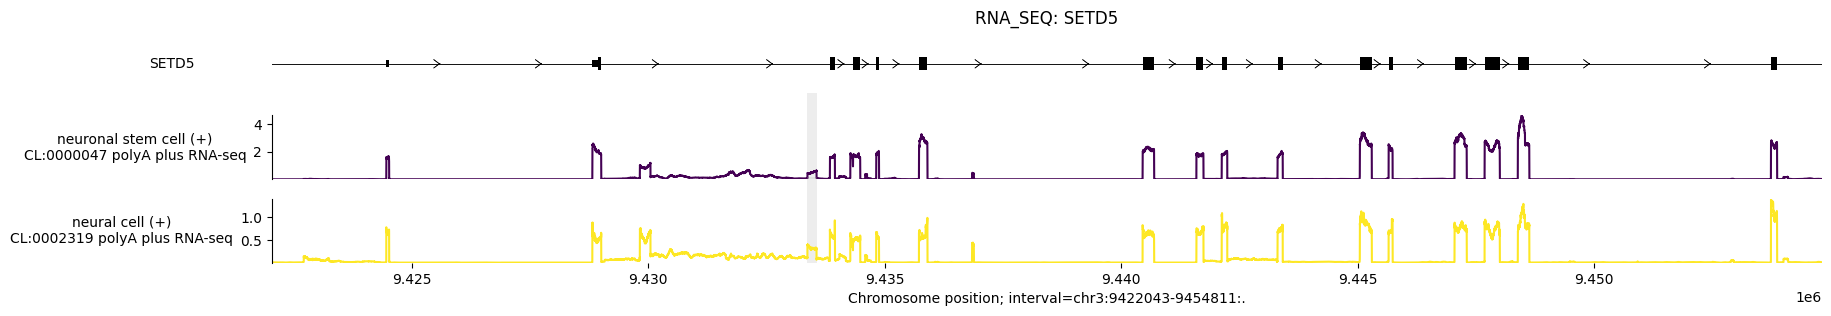

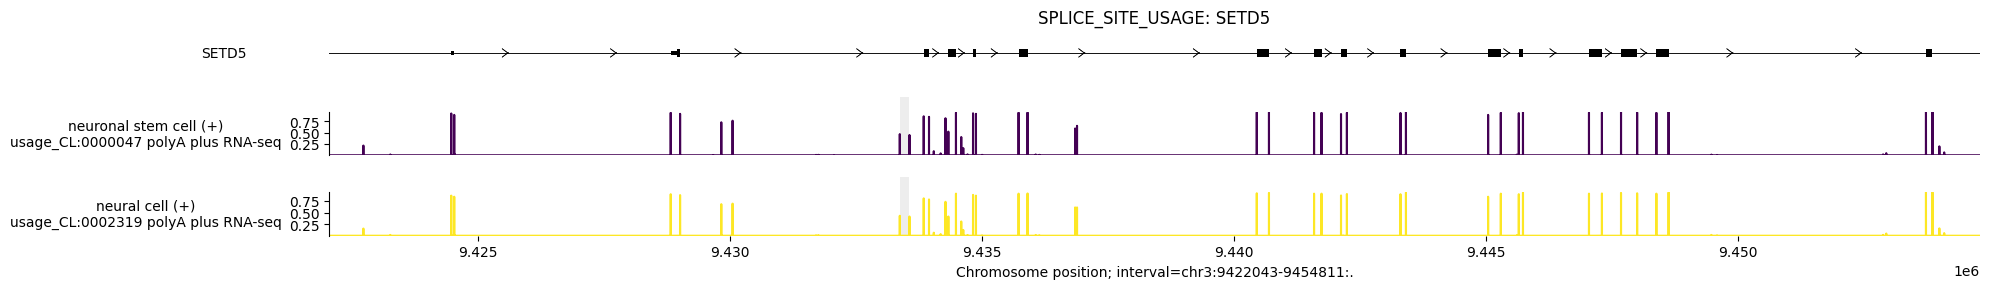

In [3]:
# Visualize predictions
viz_width = cfg.get('viz_resize_width', 2**15)
plot_all_outputs(ref_output, transcripts, requested_outputs, cfg, resize_width=viz_width, target_interval=[target_interval])

## Step 2: ASO Masking Experiments

In [4]:
# ASO variant window
from alphagenome.data.genome import Interval

variant_interval = Interval(
    chromosome=interval.chromosome,
    start=exon_start,
    end=exon_end,
).resize(cfg['flank'])

if cfg['flank'] > 1000:
    print(f"Warning: large flank {cfg['flank']} bp may use high memory.")

start_rel = variant_interval.start - interval.start
end_rel = variant_interval.end - interval.start
aso_length = cfg['ASO_length']
variants, asos = enumerate_aso_variants(ref_seq, start_rel, end_rel, aso_length)
print(f"ASO variants: {len(variants)} | length={aso_length} | window={variant_interval.start}-{variant_interval.end}")

ASO variants: 393 | length=18 | window=9433269-9433662


In [5]:
# Predict masked sequences
outputs = model.predict_sequences(
    intervals=[interval] * len(variants),
    sequences=variants,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms']
)
print(f"Predictions complete: {len(outputs)} sequences")

100%|██████████| 393/393 [00:53<00:00,  7.35it/s]

Predictions complete: 393 sequences


In [ ]:
# ASO scoring, logos, and BED export
start = exon_start - interval.start
end = exon_end - interval.start

results, plots = score_asos_and_export(
    outputs=outputs,
    ref_output=ref_output,
    requested_outputs=requested_outputs,
    cfg=cfg,
    interval=interval,
    variant_interval=variant_interval,
    asos=asos,
    samples_max=20,
    start=start,
    end=end,
    fasta_path=cfg['fasta_path'],
    start_rel=start_rel,
    aso_length=aso_length,
    results_dir=cfg['results_dir'],
    config_name=config_name,
)

results.to_csv(f"{cfg['results_dir']}/{config_name}_ASO_scores.csv", index=False)
print(results.head())

         ASO_sequence  position  ASO_RNA_SEQ  ASO_SPLICE_SITE_USAGE
0  AGAAATTATTACTCTAAT         0    -0.044876              -0.000649
1  GAAATTATTACTCTAATA         1    -0.057207              -0.000857
2  AAATTATTACTCTAATAT         2    -0.067024              -0.001025
3  AATTATTACTCTAATATT         3    -0.084943              -0.001339
4  ATTATTACTCTAATATTT         4    -0.091933              -0.001420


## Step 3: ASO Effect Scoring and Visualization

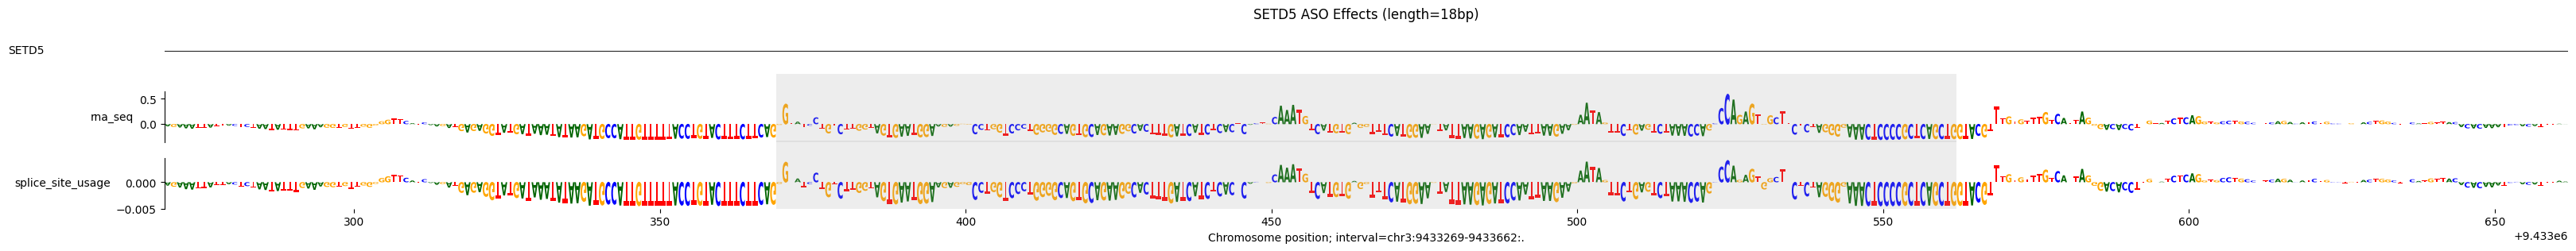

In [7]:
plot_components.plot(
    [plot_components.TranscriptAnnotation(transcripts)] + plots,
    interval=variant_interval,
    fig_width=variant_interval.width // 10,
    title=f"{cfg['gene_symbol']} ASO Effects (length={cfg['ASO_length']}bp)",
    annotations=[plot_components.IntervalAnnotation([target_interval])]
)
plt.show()